<a href="https://colab.research.google.com/github/seacatgm/-/blob/%D0%9F%D1%80%D0%BE%D0%B3%D0%BD%D0%BE%D0%B7%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5-%D0%B2%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D1%85-%D1%80%D1%8F%D0%B4%D0%BE%D0%B2/sag_motor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка данных

In [256]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt

import os

import warnings
warnings.filterwarnings("ignore")

In [257]:
step_in_the_last = 30   # По скольки шагам в прошлое определяем тренд     
n_steps = 20            # Серию из скольки баров назад анализируем         
forvard_lag = 6        # Предсказание какого бара в будущем делаем       
plato_lvl = 0.00       # Какой разброс цены считать "плато" и приравнивать к 0 в ohe при разметке Y 
analyze_period = 100000    # Сколько баров в прошлое берем для тренировки модели (чтобы ихбежать тренировки на другой динамике рынка) 

### Загрузка и первичная обработка данных

In [258]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [259]:
#Считываем данные с помощью pandas
data = pd.read_csv('/content/drive/My Drive/neuro/base/sag.csv')
data.head()
del data[data.columns[0]]

In [260]:
data.head()

,total,Sag A,Sag B,Статус
0,62.2,163.4,159.7,Работа
1,65.9,162.7,159.9,Работа
2,70.5,162.2,160.0,Работа
3,75.3,162.4,160.2,Работа
4,79.5,162.6,160.3,Работа


In [261]:
data.shape

(40304, 4)

In [262]:
def work_stop(arg): # функция для преобразования столбца "Статус" в числовые значения, Работа = 1, Простой = 0, Запуск = 0
  result = 1
  if arg != 'Работа':
    result = 0
  return result

data['Статус'] = [work_stop(cell) for cell in data['Статус']]

In [263]:
data.drop(data[data['Статус'] < 1].index, axis = 0, inplace=True) # Удаляем все случаи когда мотор не работал
data.drop(data[data['Sag A '] < 148].index, axis = 0, inplace=True) # удаляем выбросы по работе 1  двигателя
data.drop(data[data['Sag B'] < 148].index, axis = 0, inplace=True) # удаляем выбросы по работе 2  двигателя

data['total'] = data['total'].diff() # берем производную по поступлению руды
data.fillna(0, inplace = True)

data['Sag A '] = data['Sag A '].shift(periods=7, fill_value=0) # сдивагем колонку вниз, гипотеза что руда влияет через время лучший тест 6 периодов
data['Sag B'] = data['Sag B'].shift(periods=7, fill_value=0)

for i in range(len(data)): # Убираем выбросы по подаче руды, приравниваем отрицательно значение к предыдущему 
  if data.iloc[i,0] < 0:
    data.iloc[i,0] = data.iloc[i-1,0]

data.drop(data[data['total'] > 20].index, axis = 0, inplace=True)

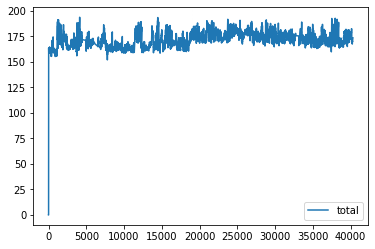

In [264]:
plt.plot(data['Sag A '],label = 'total')
plt.legend()

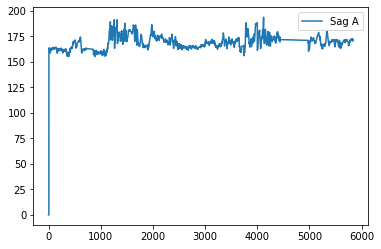

In [265]:
plt.plot(data['Sag A '][:5000],label = 'Sag A')
plt.legend()

In [266]:
data.shape

(37139, 4)

## Выделяем Y

In [267]:
# Y = 1 колонка 

data_Y = data['Sag A ']
data_Y[-6:]

40298    173.4
40299    173.5
40300    173.5
40301    173.5
40302    173.5
40303    173.6
Name: Sag A , dtype: float64

## Делим на обучающую, тестовую и валидационную выборки

### Деление на выборки train, test, val

In [268]:
data = data.values
print(data.shape, type(data))

(37139, 4) <class 'numpy.ndarray'>


In [269]:
data[:,:].shape

(37139, 4)

In [270]:
# берем для xTest последние 10-20% значений
from sklearn.model_selection import train_test_split

# разбиваем выборки train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(data[:,:], data[:,1], test_size=0.1, shuffle=False)

print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape)
xTrain.shape[0]+xTest.shape[0]

xTrain:  (33425, 4) 	yTrain: (33425,) 
xTest:   (3714, 4) 	yTest:  (3714,)


37139

### Скалирование Х

In [271]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # проверить все

# Масштабируем только X

#xScaler = StandardScaler()
xScaler = RobustScaler()
#xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

print(xTrain.shape, xTest.shape, type(xTrain))
xTest[-1:]

(33425, 4) (3714, 4) <class 'numpy.ndarray'>


array([[-0.35294118,  0.13131313,  0.1122449 ,  0.        ]])

In [272]:
# проверяю обратную трансформацию
x = xScaler.inverse_transform(xTest[-2:])
x[1][1]

173.6

### Превращение в TimeSeries

In [273]:
"""
#### Функция разделения массива на выборки для обучения нейросети 
"""
# sequence = строка массива df
# n_steps = число баров в прошлом для анализа - необходимо найти оптимальный!! если что = 1
# forvard_lag = предсказание какого бара в будущем делаем = 6 

def split_sequence(sequence, Y, n_steps = 40, forvard_lag = 6):
  # sequence = df.values - это массив из данных
  # n_steps = число баров в прошлом для анализа
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps # находим конечный индекс строки
    if end_ix + (forvard_lag-1) > len(sequence)-1: # cпроверем чтобы не выйти за пределы массива
      break 
    # получаем X и y
    seq_x, seq_y = sequence[i:end_ix], Y[end_ix + (forvard_lag - 1)]
    X.append(seq_x)
    y.append(seq_y) # тк предсказываем только Close
  return array(X), array(y)

In [274]:
# Обучающие выборки
xTrain, yTrain = split_sequence(xTrain, yTrain, n_steps, forvard_lag)

print('\nОбратите внимание на потерянные n_steps данных в начале выборки:')
print('Массивы xTrain и yTrain:\t', xTrain.shape, yTrain.shape)



Обратите внимание на потерянные n_steps данных в начале выборки:
Массивы xTrain и yTrain:	 (33400, 20, 4) (33400,)


In [275]:
xTrain[0].shape

(20, 4)

In [276]:
yTrain[1]

159.9

In [277]:
# Тестовые выборки
xTest, yTest = split_sequence(xTest, yTest, n_steps, forvard_lag)

print('\nОбратите внимание на потерянные n_steps данных в начале выборки:')
print('Массивы xTest и yTest:\t', xTest.shape, yTest.shape)



Обратите внимание на потерянные n_steps данных в начале выборки:
Массивы xTest и yTest:	 (3689, 20, 4) (3689,)


# Нейросети

In [278]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import (concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, 
                                     GRU, LSTM, Bidirectional, Conv1D, SeparableConv1D, MaxPooling1D,
                                     Reshape, RepeatVector, SpatialDropout1D, LeakyReLU, Embedding)
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop, Adamax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import utils
from keras.utils import plot_model
from IPython.display import clear_output

###Conv1D

In [279]:
# -----------------------------
# Conv1D = создаем модель
# -----------------------------

# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
  
drop = 0.4
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))

x = Flatten()(input)
x = RepeatVector(4)(x)
x = Conv1D(n_steps*2, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = RepeatVector(4)(x)
x = Conv1D(n_steps, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(n_steps*100, activation='relu')(x)
x = Dropout(drop)(x)
x = Dense(1 , activation='linear')(x)
model = Model(input, x)

print(model.summary()) #Вывод структуры модели
#plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 20, 4)]           0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 80)                0         
_________________________________________________________________
repeat_vector_14 (RepeatVect (None, 4, 80)             0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 4, 40)             16040     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 2, 40)             0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 80)                0         
_________________________________________________________________
repeat_vector_15 (RepeatVect (None, 4, 80)             0   

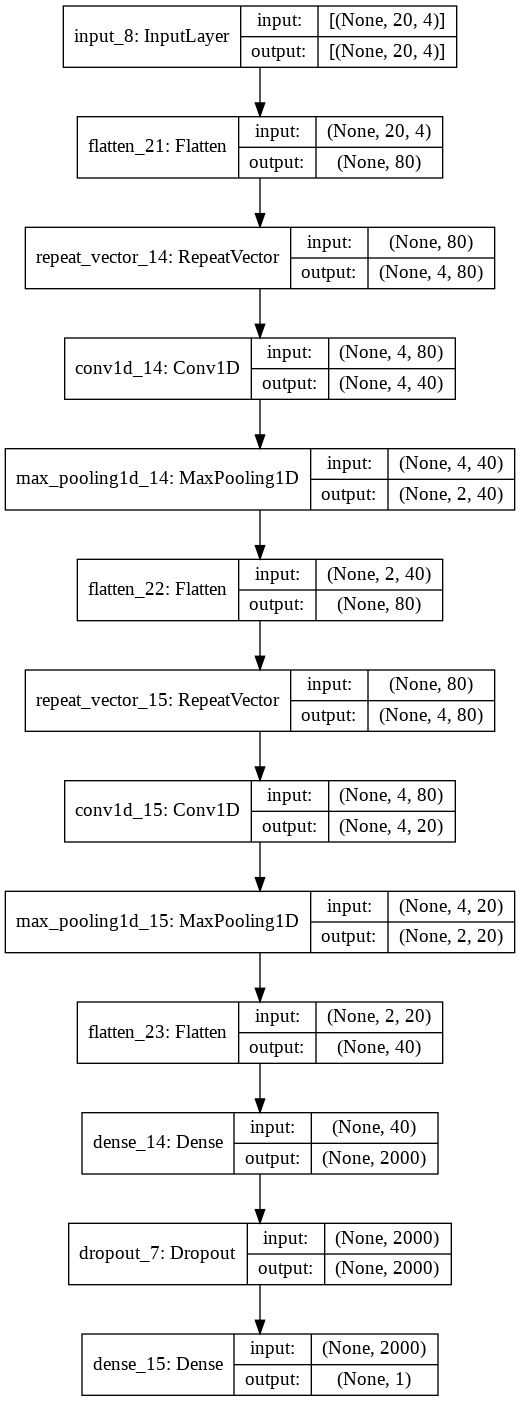

In [280]:
plot_model(model, show_shapes=True, show_layer_names=True)


Epoch 1/200
1044/1044 [==============================] - 3s 3ms/step - loss: 11826.1793 - mean_squared_error: 11826.1793 - val_loss: 2343.6667 - val_mean_squared_error: 2343.6667

Epoch 00001: val_mean_squared_error improved from inf to 2343.66675, saving model to _sag_test.h5
Epoch 2/200
1044/1044 [==============================] - 2s 2ms/step - loss: 2194.0907 - mean_squared_error: 2194.0907 - val_loss: 1154.8669 - val_mean_squared_error: 1154.8669

Epoch 00002: val_mean_squared_error improved from 2343.66675 to 1154.86694, saving model to _sag_test.h5
Epoch 3/200
1044/1044 [==============================] - 2s 2ms/step - loss: 809.3869 - mean_squared_error: 809.3869 - val_loss: 437.2370 - val_mean_squared_error: 437.2370

Epoch 00003: val_mean_squared_error improved from 1154.86694 to 437.23703, saving model to _sag_test.h5
Epoch 4/200
1044/1044 [==============================] - 2s 2ms/step - loss: 280.1232 - mean_squared_error: 280.1232 - val_loss: 190.3911 - val_mean_squared_erro

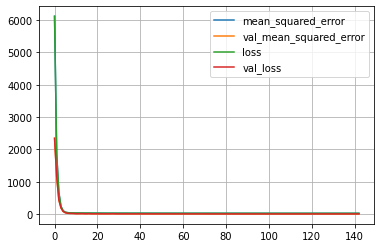

In [281]:


model.compile(optimizer=Adam(learning_rate = 1e-04),
              loss='mse', metrics = ['mean_squared_error']) 

# коллбэки

early_stopping = EarlyStopping(monitor = 'val_mean_squared_error', patience = 12, verbose = 0, 
                               restore_best_weights = True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor=0.8, patience=4, min_lr=1e-07, verbose = 1)

checkpoint = ModelCheckpoint('_sag_test.h5', monitor='val_mean_squared_error', verbose = 1,
                             save_best_only = True, mode='min')

# fit model
history = model.fit(xTrain, yTrain, epochs=200, verbose = 1,
                    validation_data=(xTest, yTest),
                    #batch_size = 1,
                    callbacks = [early_stopping, reduce_lr, checkpoint])

#clear_output()
plt.figure(figsize=(6,4))
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.grid()
plt.show()


In [282]:
# функция для постройки графиков, ошибки, предсказание/реальное значение на обучающей и тестовой выборке
def plotting(history):
  clear_output()
  print('Min al_loss = ', min(history.history['val_loss']))
  plt.figure(figsize=(7,3))
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid()
  plt.show()

  plt.figure(figsize=(16,4))
  plt.subplot(1,2,1)
  plt.plot(model.predict(xTrain), label='yTrain_pred')
  plt.plot(yTrain, label='yTrain')
  plt.legend()
  plt.grid()

  plt.subplot(1,2,2)
  plt.plot(model.predict(xTest), label='yTest_pred')
  plt.plot(yTest, label='yTest')
  plt.legend()
  plt.grid()
  plt.show()

In [283]:
model = load_model('_sag_test.h5')

# делаем предикт  и считаем среднее абсолютной ошибки и максимального отклонения
x_test = xTest
y_test_org = yTest
conv_test = []
loss_mean = float()

real_list = []
pred_list = []
critical_range =[]
critical_loss = float()
for i in range(len(x_test)):   
  x = x_test[i]
  x = np.expand_dims(x, axis=0)
  prediction = model.predict(x) 

  loss_mean = abs(100-prediction*100/y_test_org[i])
  conv_test.append(loss_mean)
  pred_list.append(prediction[0][0])
  real_list.append(y_test_org[i])
  critical_loss = prediction*100/y_test_org[i] - 100
  if critical_loss < 0:
    critical_range.append(critical_loss)

  print('Index:', i, '\tPrediction:', prediction[0][0], 'Real:', y_test_org[i],
        '\t====>', loss_mean[0][0])
print(np.array(conv_test).mean())
print(np.array(conv_test).max())

print(np.array(critical_range).mean())
print(np.array(critical_range).min())
#clear_output()




Index: 0 	Prediction: 177.69179 Real: 179.6 	====> 1.0624771
Index: 1 	Prediction: 178.37848 Real: 179.9 	====> 0.84575653
Index: 2 	Prediction: 178.79204 Real: 180.1 	====> 0.7262497
Index: 3 	Prediction: 180.80023 Real: 180.3 	====> 0.27744293
Index: 4 	Prediction: 181.08992 Real: 180.6 	====> 0.27127075
Index: 5 	Prediction: 181.33473 Real: 180.8 	====> 0.29575348
Index: 6 	Prediction: 181.09349 Real: 181.0 	====> 0.05165863
Index: 7 	Prediction: 180.90256 Real: 181.2 	====> 0.16414642
Index: 8 	Prediction: 181.6328 Real: 181.4 	====> 0.12833405
Index: 9 	Prediction: 181.19748 Real: 181.6 	====> 0.2216568
Index: 10 	Prediction: 180.96204 Real: 181.8 	====> 0.46092987
Index: 11 	Prediction: 180.70273 Real: 181.5 	====> 0.4392624
Index: 12 	Prediction: 180.80136 Real: 180.8 	====> 0.00075531006
Index: 13 	Prediction: 180.20786 Real: 181.0 	====> 0.4376526
Index: 14 	Prediction: 180.77196 Real: 181.8 	====> 0.5654831
Index: 15 	Prediction: 180.79977 Real: 181.0 	====> 0.11062622
Index:

In [289]:
print('Средняя абсолютная ошибка ', 0.7457481)
print('Максимальная ошибка от реального значения ',8.188988)

Средняя абсолютная ошибка  0.7457481
Максимальная ошибка от реального значения  8.188988


In [303]:
p= []
for i in conv_test:
  if i > 3:
    p.append(i)
print(len(p))

92


Min al_loss =  4.05540132522583


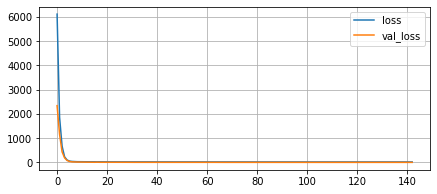

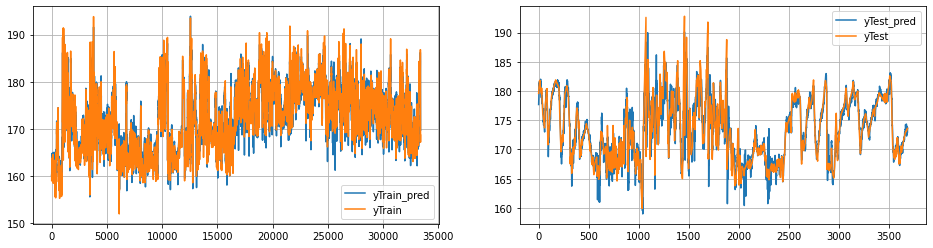

In [286]:
plotting(history)

3689

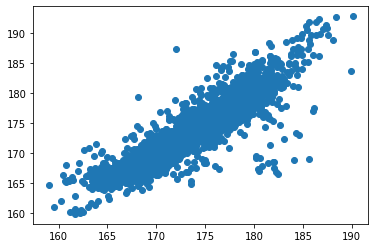

In [287]:
plt.scatter(x = pred_list, y = real_list)
len(real_list)

In [290]:
df_plot = pd.DataFrame({'Pred': pred_list, 'Real': real_list})
df_plot.head()

,Pred,Real
0,177.691788,179.6
1,178.378479,179.9
2,178.792038,180.1
3,180.800232,180.3
4,181.089920,180.6


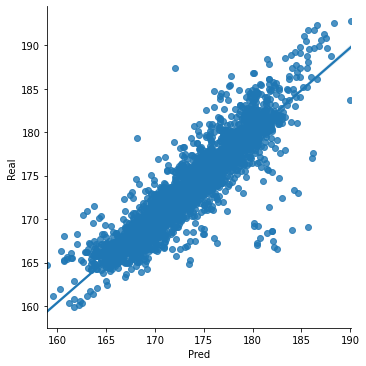

In [302]:
import seaborn as sns

sns.lmplot(data=df_plot, x='Pred', y='Real', palette=sns.color_palette("YlGn"))


In [288]:
import requests

api_token = '1424770146:AAFNAdGQZYe8yykuxxcsgp-_82quSucorEI'
text = ('результат '+ str(np.array(conv_test).max()) + '\n'+ ' среднеее  '+ str(np.array(conv_test).mean()))
requests.get('https://api.telegram.org/bot{}/sendMessage'.format(api_token), params=dict(chat_id='@earthneuro', text=text))

<Response [200]>